# Gantry spherical scan

Author: Blair Jamieson
Date: December 2023

## Gantry coordinates.

The long axis of the gantry is $x$, the other horizontal axis is $y$, and the vertical axis is $z'$.  Note that the gantry motion in $x$ and $y$ are correct, while the motion in $z$ starts at $z=z'=0$ and as the gantry $z'$ coordinate is increased $z=-z'$.

The end of the gantry's $xyz$ motion is at $\vec{r}_g$ and the location of the calibration target $\vec{r}_t'$ relative to that position depends on the rotation in the $xy$-plane $\phi_g$, and the rotation relative to the $z$ axis $\theta_g$.

$$ \vec{r}_t' = 25\ \rm{cm}\ ( \sin{\phi_g} \hat{i} + \cos{\phi_g} \hat{j} ) $$

The location of the target in gantry coordinates is:

$$ \vec{r}_t = \vec{r}_g + \vec{r}_t' $$

$$ \vec{r}_t = (x_g + 25\ \rm{cm}\ \sin{\phi_g})\hat{i} + (y_g + 25\ \rm{cm}\  \cos{\phi_g})\hat{j} - z_g'\hat{k}$$

The pointing of the calibration target (normal to the checkerboard pattern) is $\hat{n}_t$.  Note that the angle $\theta_g$ is the true spherical coordinates angle from the $z$-axis, but $\phi_g$ is measured going positive going counter-clockwise from the $y$-axis.  Therefore the true spherical coordinate $\phi = 90^{\circ} - \phi_g$.  The normal to the calibration target is:

$$\hat{n}_t = \sin{\theta_g}\cos{\phi_g}\hat{i} - \sin{\theta_g}\sin{\phi_g}\hat{j} + \cos{\theta_g}\hat{k}$$

In the gantry coordinates we define the camera position $\vec{r}_c$ and its facing $\hat{n}_c$.

## Scan semi-sphere around camera

Suppose we want to scan a semi-spherical plane around the camera.  How do we equally space the points on the surface of the sphere?  See for example https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf

The basic idea is to keep the solid angle between points constant, where

$$dA = r^2 \sin{\theta} d\theta d\phi= r d(r\cos{\theta}) d\phi = rdzd\phi$$

Choose circles of latitude at constant intervals $d_{\theta}$, and on each circle space points by distance $d_{\phi}$ such that $d_{\theta}\sim d_{\phi}$.  Suppose we want $N$ points in total.  Then:

```
dA = 4 * pi / N # as solid angle
d = sqrt( dA )
Mtheta = round( pi / d )
dtheta = pi / Mtheta
dphi = dA / dtheta
for m in range(Mtheta):
    theta = pi * ( m + 0.5 ) * m / Mtheta
    Mphi = round( 2*pi*sin(theta) / d_theta )
    for n in range(Mphi):
        phi = 2 * pi * n / Mphi
        rcvec = r * [ sin( theta )*cos(phi), 
                       sin( theta )*sin(phi),
                       cos( theta ) ]
```

Now lets consider that we don't want to scan a full sphere, since we are limited to some range of coordinates in the gantry.  Instead, lets pick a number of scan points $N$ as before, and then start and end points in $\theta$ and $\phi$.  Eg. five parameters for the scan are specified: $(N,\theta_{1},\theta_{2}, \phi_{1}, \phi_{2})$, where the ranges are chosen to allow the points in the scan to be possible for the gantry to accomplish.  

The cross sectional area covered is no longer $4\pi$, but is:

$$ dA = \Delta \phi ( \cos{ \theta_{1} } - \cos{ \theta_{2}} )$$
$$\Delta \phi = \phi_{2} - \phi_{1}$$

The updated code becomes:

```
dA = (phi2-phi1) * ( cos(theta1) - cos(theta2) ) / N
d = sqrt( dA )
Mtheta = round( (theta2 - theta1) / d )
dtheta = (theta2 - theta1) / Mtheta
dphi = dA / dtheta
for m in range(Mtheta):
    theta = theta1 + (theta2-theta1) * ( m + 0.5 ) * m / Mtheta
    Mphi = round( (phi2-phi1)*sin(theta) / d_theta )
    for n in range(Mphi):
        phi = phi1 +  (phi2-phi1) * n / Mphi
        rcvec = rc * [ sin( theta )*cos(phi), 
                       sin( theat )*sin(phi),
                       cos( theta ) ]
```


## Rotate from camera coords to gantry coords

In the camera coordinates, define the scan point a distance $r$ from the camera as $\vec{r'}$, and in gantry coordinates the normal to the camera as $\hat{n}$.  To keep things simple, lets assume the camera coordinate $z$-axis is the same as the gantry coordinate $z$-axis, then the rotation is just in the plane. ie. $\vec{n}$.  The angle $\phi'$ in the gantry coordinates then depends on the angle $\phi'$ between the normal and the gantry x-axis:

$$ \phi' = {\rm arctan2}{( n_y, n_x )}$$



In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gantry_spherical_scan import camera
from gantry_spherical_scan import get_gantry_settings
from mpl_toolkits.mplot3d import Axes3D


In [31]:
# Test the code
deg2rad   = np.pi/180.0

Nscan     = 200
Rscan     = 450.0 # mm
#campos    = [900.0, 830.0, -730.0] #mm
campos = [900.0, 580.0, -730.0] #mm
camfacing = [1.0, 0.0, 0.0]
phimin    = -10.0 * deg2rad
phimax    = 10.0 * deg2rad
thetamin  = 20.0 * deg2rad
thetamax  = 79.0 * deg2rad

c1 = camera( campos, camfacing )

scanpts = c1.get_scanpoints(N=Nscan,r=Rscan, 
                            phi1=phimin, phi2=phimax,
                            theta1=thetamin, theta2=thetamax)
npscanpts=np.array(scanpts)

Text(0.5, 0.92, 'Pos relative to camera')

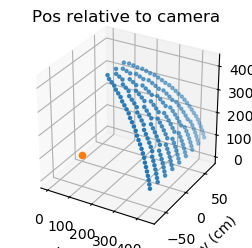

In [32]:
X=npscanpts.T[0]
Y=npscanpts.T[1]
Z=npscanpts.T[2]
fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.scatter(X,Y,Z,marker='.')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')
ax.scatter(0.,0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

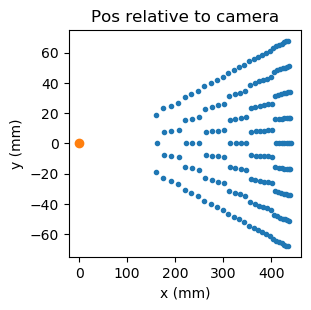

In [33]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(X,Y,'.')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

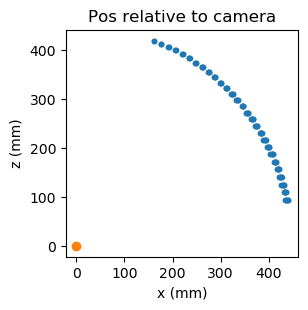

In [34]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(X,Z,'.')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

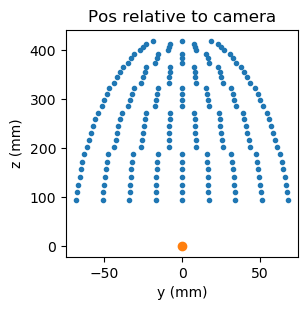

In [35]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(Y,Z,'.')
plt.xlabel('y (mm)')
plt.ylabel('z (mm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

## Now calculate position and rotation of gantry

Now that we have a list of camera vectors $\vec{r}$ in gantry coordinates, we want to calculate the vector $\vec{r}_g$, $\theta_g$, and $\phi_g$ (the x,y,z of the gantry and its rotation).  This position is such that:

$$\vec{r}_g+\vec{r}_t = \vec{r}_c + \vec{r}$$

$$\vec{r}_g = \vec{r}_c + \vec{r} - \vec{r}_t$$

The vector $\vec{r}$ and $\vec{r}_c$ we get from the camera.  The vector $\vec{r}_t$ depends on the normal vector of $-\vec{r}$ (the target facing $\hat{n_t}$).  We find:

$$ \hat{n_t} = -\frac{\vec{r}}{r} $$
$$ \phi = \rm{arctan2}( n[1] , n[0] )$$
$$ \theta = \rm{arctan2}\left( \frac{n[2]}{\sqrt{n[0]^2+n[1]^2} } \right)$$

The gantry facing is then $\phi_g=\phi$ and $\theta_g=\theta$.  The gantry target vector is:

$$ \vec{r}_t' = 25\ \rm{cm}\ ( -\sin{\phi_g} \hat{i} + \cos{\phi_g} \hat{j} ) $$



In [36]:
gsets, tls = get_gantry_settings( c1, scanpts, 250)

Text(0.5, 0.92, 'Gantry position')

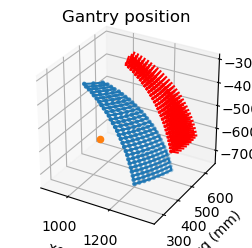

In [37]:

npgsets = np.array(gsets)
GX = npgsets.T[0]
GY = npgsets.T[1]
GZ = npgsets.T[2]
Gphi = npgsets.T[3]
Gtheta = npgsets.T[4]

nptls = np.array(tls)
TX = nptls.T[0]
TY = nptls.T[1]
TZ = nptls.T[2]

NX = nptls.T[3]
NY = nptls.T[4]
NZ = nptls.T[5]

fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.plot(GX,GY,GZ)
ax.scatter(GX,GY,GZ,marker='.')
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o')

ax.quiver(GX+TX,GY+TY,GZ+TZ,NX,NY,NZ,length=50.0,color='r')
ax.set_xlabel('xg (mm)')
ax.set_ylabel('yg (mm)')
ax.set_zlabel('zg (mm)')
ax.set_title('Gantry position')
#plt.savefig()

IndexError: index 207 is out of bounds for axis 0 with size 193

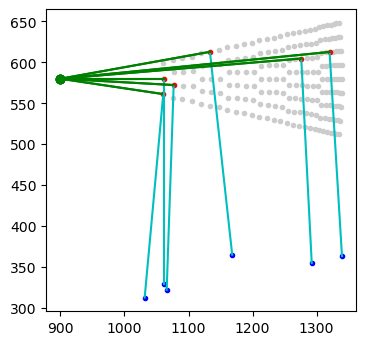

In [38]:
plt.figure(figsize=(4,4),dpi=100)

plt.plot( GX+TX, GY+TY, '.',color='0.8')
ptnum=0
plt.plot( GX[ptnum], GY[ptnum],'.',color='b',label='gantry pos')
#plt.plot( [0.,GX[ptnum]], [0.,GY[ptnum]], color='k',label='rg')
plt.plot(GX[ptnum]+TX[ptnum],GY[ptnum]+TY[ptnum],'.',color='r',label='target center')
plt.plot( [GX[ptnum],GX[ptnum]+TX[ptnum]], [GY[ptnum],GY[ptnum]+TY[ptnum]], color='c', label='rt')
plt.plot( [GX[ptnum]+TX[ptnum], c1.rc[0]], [ GY[ptnum]+TY[ptnum], c1.rc[1]], color='g')
plt.plot( [c1.rc[0],c1.rc[0]+X[ptnum]], [c1.rc[1],c1.rc[1]+Y[ptnum]], color='g', label='r')
plt.plot( c1.rc[0], c1.rc[1], marker='o', color='g', label='camera pos')

for ptnum in [1,5,20,100,150,207]:
    plt.plot( GX[ptnum], GY[ptnum],'.',color='b')
    #plt.plot( [0.,GX[ptnum]], [0.,GY[ptnum]], color='k')
    plt.plot(GX[ptnum]+TX[ptnum],GY[ptnum]+TY[ptnum],'.',color='r')
    plt.plot( [GX[ptnum],GX[ptnum]+TX[ptnum]], [GY[ptnum],GY[ptnum]+TY[ptnum]], color='c')
    plt.plot( [GX[ptnum]+TX[ptnum], c1.rc[0]], [ GY[ptnum]+TY[ptnum], c1.rc[1]], color='g')
    plt.plot( [c1.rc[0],c1.rc[0]+X[ptnum]], [c1.rc[1],c1.rc[1]+Y[ptnum]], color='g')
    plt.plot( c1.rc[0], c1.rc[1], marker='o', color='g')
plt.xlabel('gx (mm)')
plt.ylabel('gy (mm)')
plt.title('gantry position')
plt.xlim([400,1400])
plt.ylim([0,1000])

plt.legend(loc='upper left')

Text(0.5, 1.0, 'gantry position')

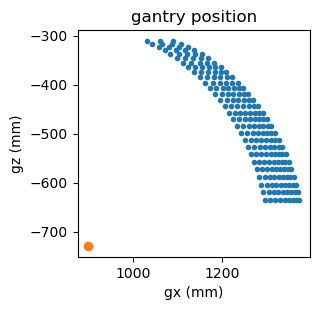

In [39]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gx (mm)')
plt.ylabel('gz (mm)')
plt.title('gantry position')

Text(0.5, 1.0, 'gantry position')

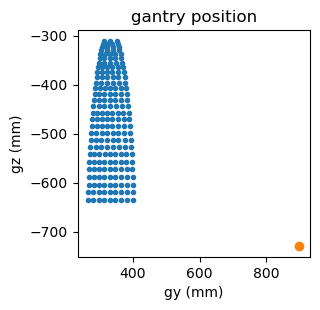

In [40]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GY,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gy (mm)')
plt.ylabel('gz (mm)')
plt.title('gantry position')

Text(0.5, 0.92, 'Target position and pointing')

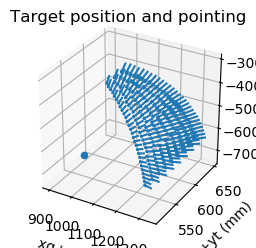

In [41]:


fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.quiver(GX+TX,GY+TY,GZ+TZ,NX,NY,NZ,length=50.0)
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o')

ax.set_xlabel('xg+xt (mm)')
ax.set_ylabel('yg+yt (mm)')
ax.set_zlabel('zg+zt (mm)')
ax.set_title('Target position and pointing')

Text(0.5, 0.92, 'Gantry position')

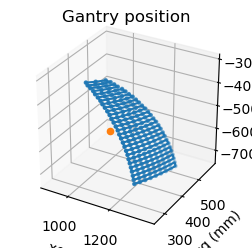

In [42]:

fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.plot(GX,GY,GZ)
ax.scatter(GX,GY,GZ,marker='.')
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o')
ax.set_xlabel('xg (mm)')
ax.set_ylabel('yg (mm)')
ax.set_zlabel('zg (mm)')
ax.set_title('Gantry position')

Text(0.5, 1.0, 'target position')

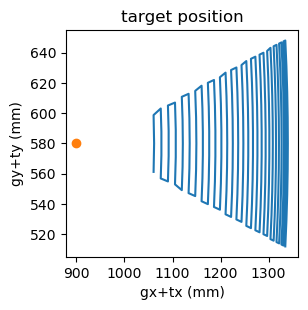

In [43]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX+TX,GY+TY)
plt.plot( c1.rc[0], c1.rc[1],  marker='o')
plt.xlabel('gx+tx (mm)')
plt.ylabel('gy+ty (mm)')
plt.title('target position')

Text(0.5, 1.0, 'target position')

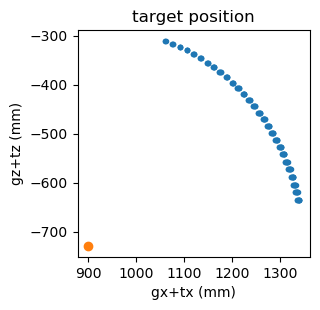

In [44]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX+TX,GZ+TZ,'.')
#plt.plot(GX,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gx+tx (mm)')
plt.ylabel('gz+tz (mm)')
plt.title('target position')

In [45]:
# actual number of scan points?
print('N scan points =',len(X))

N scan points = 193


In [25]:
from tabulate import tabulate
print()
print(tabulate( np.concatenate( (npgsets , nptls),axis=1) ,\
               headers=['xg','yg','zg','phig','thetag','xt','yt','zt','ntx','nty','ntz'],\
               floatfmt=['.1f','.1f','.1f','.3f','.3f','.1f','.1f','.1f','.3f','.3f','.3f' ] ))

ModuleNotFoundError: No module named 'tabulate'

In [26]:
rad2deg   = 180.0/np.pi
print('Minimum tgt x = ',np.min( GX+TX ),'mm')
print('Maximum tgt x = ',np.max( GX+TX ),'mm')
print('Minimum tgt y = ',np.min( GY+TY ),'mm')
print('Maximum tgt y = ',np.max( GY+TY ),'mm')
print('Minimum tgt z = ',np.min( GZ+TZ ),'mm')
print('Maximum tgt z = ',np.max( GZ+TZ ),'mm')
print('Minimum gtry x = ',np.min( GX ),'mm')
print('Maximum gtry x = ',np.max( GX ),'mm')
print('Minimum gtry y = ',np.min( GY ),'mm')
print('Maximum gtry y = ',np.max( GY ),'mm')
print('Minimum gtry z = ',np.min( GZ ),'mm')
print('Maximum gtry  z = ',np.max( GZ ),'mm')
print('Minimum phi=',np.min( Gphi )*rad2deg,'deg')
print('Maximum phi=',np.max( Gphi )*rad2deg,'deg')
print('Minim theta=',np.min( Gtheta )*rad2deg,'deg')
print('Maxim theta=',np.max( Gtheta )*rad2deg,'deg')

Minimum tgt x =  496.93294234748146 mm
Maximum tgt x =  1303.0670576525185 mm
Minimum tgt y =  142.76909760632373 mm
Maximum tgt y =  501.2208571752178 mm
Minimum tgt z =  -623.5615765242103 mm
Maximum tgt z =  -314.80277339403597 mm
Minimum gtry x =  396.4844084286511 mm
Maximum gtry x =  1206.1881610394928 mm
Minimum gtry y =  76.58013651149443 mm
Maximum gtry y =  723.9724882223097 mm
Minimum gtry z =  -623.5615765242103 mm
Maximum gtry  z =  -314.80277339403597 mm
Minimum phi= -67.19999999999999 deg
Maximum phi= 67.19999999999999 deg
Minim theta= -67.31818181818183 deg
Maxim theta= -13.681818181818196 deg


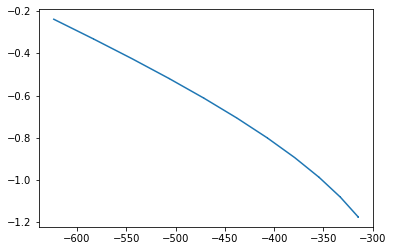

In [27]:
plt.plot( GZ, Gtheta )

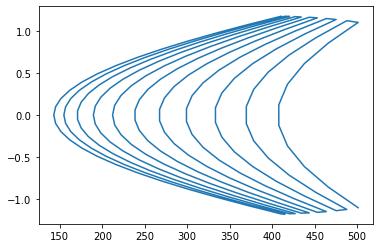

In [28]:
plt.plot( GY+TY, Gphi )